In [1]:
#std modules
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.spatial.distance import cdist,pdist,squareform
from sklearn import datasets, metrics
from sklearn.cluster import DBSCAN,KMeans,MeanShift,estimate_bandwidth
from sklearn.neighbors import kneighbors_graph
from sklearn.decomposition import PCA
import sklearn.preprocessing

%matplotlib inline

#import custom functions and classes
import myclusters2
import mymetrics2

In [4]:
example_dist=np.loadtxt("example_distances.dat.gz")

In [5]:
def dcolumn2mat(data):
    ndata = int(np.max(data[:,1]))
    D = np.zeros(ndata*ndata)
    D.shape = (ndata,ndata)
    for line in data:
        I = int(line[0])-1
        J = int(line[1])-1
        D[I,J] = line[2]
        D[J,I] = line[2]
    return(D)

In [6]:
def plot_histo(x, ignore=None):
    "Generate and plot a histogram for some data. The optional ignore is a histogram index to 0 out."
    h,b = np.histogram(x)
    if ignore is not None: h[ignore] = 0
    c = (b[:-1]+b[1:])/2
    w = 0.7*(b[1]-b[0])
    return plt.bar(c,h,align='center',width=w)
colors=['red','green','blue','yellow','orange','cyan','magenta']

Data set size:  (2000, 2000)
Maximum distance:  1.232


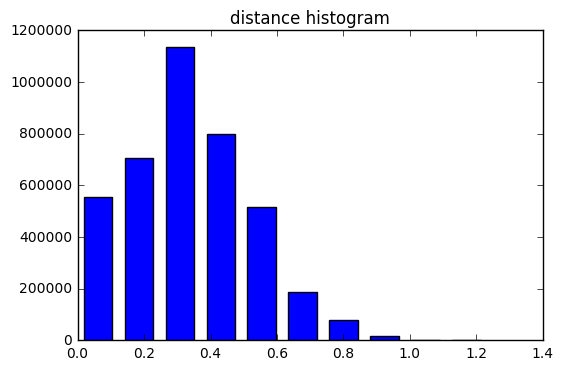

In [7]:
D=dcolumn2mat(example_dist)
print("Data set size: ",D.shape)
print("Maximum distance: ",np.max(D))
tt=plot_histo(D)
plt.title(r"distance histogram")

In [8]:
cutoff = 0.033
#cutoff = "auto"
estimator = myclusters2.density_peaks(cutoff=cutoff,kernel="gaussian",\
                                     metric="precomputed",D=D)
                                     #metric="euclidean",X=np.loadtxt("fig2_panelB.dat"))
print("Cutoff: ",estimator.cutoff)
rho,delta = estimator.decision_graph()
nneigh = estimator.nneigh
print(len(nneigh))
np.any(nneigh==0.)

Cutoff:  0.033
2000


True

Average and std of rho: 37.7626694224 34.3902394127


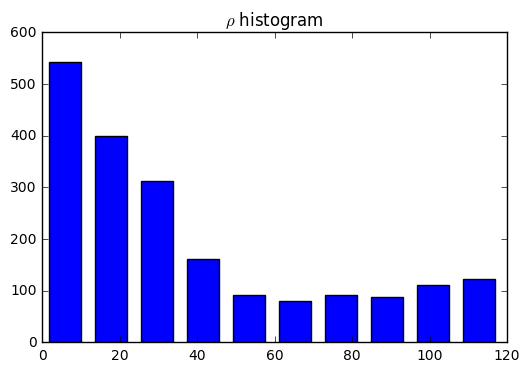

In [9]:
tt=plot_histo(rho)
print("Average and std of rho:",np.mean(rho),np.std(rho))
plt.title(r"$\rho$ histogram")

Average and std of rho: 0.0114315 0.0173473141365


[0, 0.35, 0, 40]

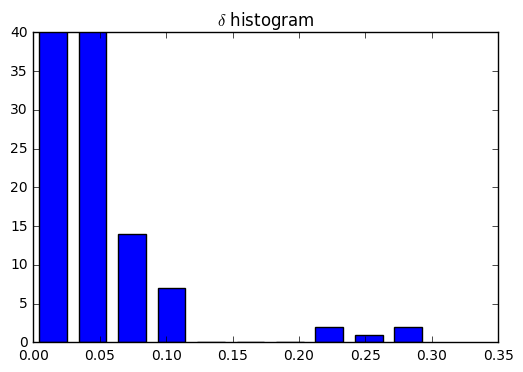

In [10]:
tt = plot_histo(delta)
print("Average and std of rho:",np.mean(delta),np.std(delta))
plt.title(r"$\delta$ histogram")
plt.axis([0,0.35,0,40])

[0, 400, 0, 0.35]

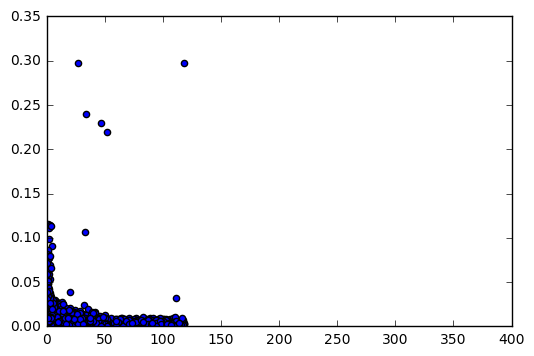

In [11]:
plt.scatter(rho,delta)
plt.axis([0,400,0,0.35])

In [12]:
centroids,points = estimator.get_centroids(rmin=20,dmin=0.1)
print("Found ",estimator.nclusters," clusters")
print("Cores: ",centroids)

Found  6  clusters
Cores:  [ 110  148  450 1309 1348 1578]


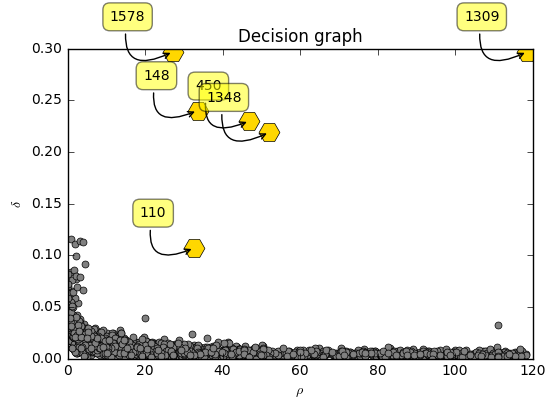

In [13]:
plt.plot(rho[points], delta[points], 'o', markerfacecolor="gray",\
    markeredgecolor='k', markersize=5)

plt.plot(rho[centroids], delta[centroids], 'H', markerfacecolor="gold",\
    markeredgecolor='k', markersize=15)

for c, x, y in zip(centroids, rho[centroids], delta[centroids]):
    plt.annotate(
        c,
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=1'))

plt.xlabel(r"$\rho$")
plt.ylabel("$\delta$")
plt.title('Decision graph')

In [14]:
clusters = estimator.assign_points()
print(clusters)
for c in centroids:
    N = len(clusters[clusters==c])
    print("%d elements found in cluster %d" % (N,c))

[ 110  110  110 ..., 1309  450 1309]
161 elements found in cluster 110
217 elements found in cluster 148
326 elements found in cluster 450
884 elements found in cluster 1309
297 elements found in cluster 1348
115 elements found in cluster 1578


In [15]:
robust_clusters = estimator.create_halo()
for c in centroids:
    N = len(robust_clusters[robust_clusters==c])
    H = len(clusters[clusters==c]) - N
    print("%d elements and %d HALO points found in cluster %d" % (N,H,c))

16 elements and 145 HALO points found in cluster 110
18 elements and 199 HALO points found in cluster 148
250 elements and 76 HALO points found in cluster 450
785 elements and 99 HALO points found in cluster 1309
208 elements and 89 HALO points found in cluster 1348
115 elements and 0 HALO points found in cluster 1578


In [ ]:
# %load myclusters2.py
import numpy as np
from math import exp,sqrt
from scipy.spatial.distance import cdist,pdist,squareform

def size_indep_rho(RMSD,rgyr):
    D2  = RMSD**2
    R2  = rgyr**2
    R2i = np.expand_dims(R2,axis=0).T
    rho = 2.*RMSD / np.sqrt(R2+R2i-D2)
    return rho

def check(RMSD,rgyr):
    npoints = rgyr.shape[0]
    rho = np.zeros((npoints,npoints))
    for i in range(npoints-1):
        for j in range(i,npoints):
            szind = 2.*RMSD[i,j]/np.sqrt(rgyr[i]**2+rgyr[j]**2-RMSD[i,j]**2)
            rho[i,j] = szind
            rho[j,i] = szind
    return rho

class density_peaks:
    def __init__(self,**kwargs):
        self.metric = "euclidean"
        self.kernel = "gaussian"
        self.D = None
        self.X = None
        self.cutoff = 0.0
        percent = 2.0
        kernels = ["flat","gaussian"]
        for key, value in kwargs.items():
            if key=="cutoff":
                self.cutoff = value
            if key=="metric":
                self.metric = value
            if key=="X":
                self.X = value
            if key=="D":
                self.D = value
            if key=="percent":
                percent = value
            if key=="kernel":
                self.kernel = value
        if self.metric=="precomputed" and self.D is None:
            raise ValueError("missing precomputed distance matrix")
        elif self.X is not None:
            self.D = squareform(pdist(self.X,metric=self.metric))  
        if self.kernel not in kernels:
            raise NotImplementedError("no kernel %s %s in" \
            % (self.kernel,self.__class__.__name__))
        self.N = self.D.shape[0]
        if self.cutoff == 0.0:
            raise ValueError("cutoff must > 0")
        elif self.cutoff=="auto":
            print("Determining cutoff using a % of neighbors=",percent)
            self.cutoff = self.use_percent(percent)

    def use_percent(self,perc):
        """
        calculate average distance so that
        average number of neighbors within
        is perc of total points
        """
        dd = np.sort(self.D.ravel())
        N = dd.shape[0]
        frac = N*perc/100. 
        cutoff = dd[int(frac)]
        return cutoff

    def calc_rho(self):
        """
        calculate local density
        """
        rho = np.zeros(self.N)
        for i in range(self.N):
            mydist = self.D[i,:]
            if self.kernel == "flat":
                dens = float(len(mydist[mydist<self.cutoff]))-1.
            elif self.kernel == "gaussian":
                dens = np.sum(np.exp( -(mydist/self.cutoff)**2 ))-1
            rho[i] = dens
        rank = np.argsort(rho)[::-1]
        return rho,rank

    def calc_delta(self):
        """
        loop on ordered densities; for each point find
        minimum distance from other points with higher density
        the point with the highest density is assigned as 
        neighbor to build cluster
        """
        maxd = np.max(self.D)
        nneigh = np.zeros(self.N,dtype=np.int64)
        delta  = maxd*np.ones(self.N)
        delta[self.order[0]] = -1.
        for i in range(1,self.N):
            I = self.order[i]
            Imin = self.order[:i]
            dd = np.min(self.D[I,Imin])
            delta[I] = dd
            nn = self.order[np.where(self.D[I,Imin]==dd)[0][0]]
            nneigh[I] = nn
        delta[self.order[0]] = np.max(delta)
        #delta[self.order[0]] = np.max(self.D[self.order[0]])
        return delta,nneigh

    def decision_graph(self):
        """
        calculate decision graph for data set
        """
        self.rho,self.order = self.calc_rho()
        self.delta,self.nneigh = self.calc_delta()
        return self.rho,self.delta

    def get_centroids(self,**kwargs):
        """
        search for points above level of mean 
        values of rho and delta for candidate 
        cluster centroids and for outliers
        """
        rmin = 0.0
        dmin = 0.0
        for key,value in kwargs.items():
            if key=="rmin":
                rmin = value
            if key=="dmin":
                dmin = value
        rmask = self.rho   > rmin
        dmask = self.delta > dmin
        self.centroids = np.where(rmask & dmask)[0]
        self.nclusters = len(self.centroids)
        self.points = np.where((~rmask) | (~dmask))[0]
        return self.centroids, self.points

    def assign_points(self):
        """
        assign a point to the same cluster 
        of its nearest neighbor with highest 
        density
        """
        self.clusters = -np.ones(self.N,dtype=np.int64)
        #initialize cluster labels to centroids
        for i in self.centroids:
            self.clusters[i] = i
        for point in self.order:
            if self.clusters[point] == -1:
                self.clusters[point] = self.clusters[self.nneigh[point]]
        if np.any(self.clusters==-1):
            raise ValueError("Error: Unassigned points are present")
        return self.clusters

    def create_halo(self):
        """
        create halo of points for each cluster that
        may be assigned as noise
        """
        self.robust_clusters = -np.ones(self.N,dtype=np.int64)
        rho_b = dict()
        for myc in self.centroids:
            rho_b[myc] = 0.0
            NN = np.asarray(list(range(self.N)))
            intpoints  = self.clusters == myc
            extpoints = ~intpoints
            intpoints = NN[intpoints]
            extpoints = NN[extpoints]
            for i in intpoints:
                for j in extpoints:
                    if self.D[i,j] <= self.cutoff:
                        rho_b[myc] = max(0.5*(self.rho[i]+self.rho[j]),rho_b[myc])
        for p,P in enumerate(self.clusters):
            if self.rho[p] >= rho_b[P]:
                self.robust_clusters[p] = self.clusters[p]
        return self.robust_clusters
